# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make conclusions) then **text answer** is **mandatory** and **is** part of the task
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 

In [2]:
from typing import Tuple, List

import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from mpl_toolkits import mplot3d

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model is parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

$$\nabla_wL(w, w_0) = \frac{1}{N} \sum_{i=1}^N \frac{(1+\exp(-y_i(w^\top x_i+w_0)))'}{(1+\exp(-y_i(w^\top x_i+w_0)))} + \gamma sign(w) + 2\beta w$$ 
$$= \frac{1}{N} \sum_{i=1}^N \frac{-y_ix_i\exp(-y_i(w^\top x_i+w_0)}{(1+\exp(-y_i(w^\top x_i+w_0)))} + \gamma sign(w) + 2\beta w$$
$$= -\frac{1}{N} \sum_{i=1}^N y_ix_i\frac{\exp(-y_i(w^\top x_i+w_0)}{(1+\exp(-y_i(w^\top x_i+w_0)))} + \gamma sign(w) + 2\beta w$$

$$\nabla_{w_0}L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \frac{(1+\exp(-y_i(w^\top x_i+w_0)))'}{(1+\exp(-y_i(w^\top x_i+w_0)))}$$ 
$$= \frac{1}{N} \sum_{i=1}^N \frac{-y_i\exp(-y_i(w^\top x_i+w_0)}{(1+\exp(-y_i(w^\top x_i+w_0)))}$$
$$= -\frac{1}{N} \sum_{i=1}^N y_i\frac{\exp(-y_i(w^\top x_i+w_0)}{(1+\exp(-y_i(w^\top x_i+w_0)))}$$

```Тут просто ручное дифференциирование```<br/>

**Reminder!**
Do not use loops in task 2 and task 3. Loss and grad functions should be implemented in matrix form, without loops.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [3]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    
    """
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    """
    N = len(X)
    summ = np.sum(np.log(1 + np.exp(-y * (np.dot(X, w.T) + w0))))
    res = summ / N + gamma * np.sum(np.abs(w)) + beta * np.linalg.norm(w)
    return res

#### 3. [0.5 points] Implement the gradient (as a function)

In [4]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    '''
    N = len(X)
    
    exp = np.exp(-y * (np.dot(X, w.T) + w0))
    
    fraction = exp / (1 + exp)
    
    summ_w = np.dot(fraction * y, X)
    summ_w0 = np.sum(fraction * y)
    
    res_w = - summ_w / N + gamma * np.sign(w) + 2 * beta * w
    res_w0 = - summ_w0 / N
    
    return res_w, res_w0

#### Check yourself

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [7]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta = 1.0, gamma = 1.0, lr = 1e-2, tolerance = 1e-8, max_iter = 1000, random_state = 42):  
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        
        '''
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        
        self.loss_history = []
        self.borderline = 0.5
        self.lr = self.learning_rate
        self.classes_ = [-1, 1]
        self.tpr = 0
        self.fpr = 0
        self.zeros = False
        
    def update_treshold(self, X, y):
        
        fpr, tpr, borderline = roc_curve(y, self.predict_proba(X).T[1,:])
        self.borderline = borderline[np.argmax(tpr - fpr)]
        self.tpr = tpr
        self.fpr = fpr
        
    def fit(self, X, y):
        
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        if 0 in y:
            y = np.where(y==0, -1, 1)
            self.zeros = True
            
        self.w0 = 1
        self.w = np.ones(len(X[0]))
        
        for i in range(self.max_iter):
            
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
                            
            old_w = self.w
            self.w = self.w - grad_w * self.learning_rate
            self.w0 = self.w0 - grad_w0 * self.learning_rate
            
            loss_val = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(loss_val)
        
            self.update_treshold(X, y)
            
            if self.tolerance >= np.linalg.norm(self.w - old_w):
                break
        
        return self
     
    
    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        
        '''
        probs = (self.predict_proba(X)).T
        
        res = np.ones(probs.shape[1])
        if self.zeros == False:
            res[self.borderline > probs[1, :]]  = -1
        else: 
            res[self.borderline > probs[1, :]]  = 0
        
        return res
    
    def predict_proba(self, X):
        '''
        Function that estimates probabilities 

        '''
        first = 1 / (1 + np.exp(np.dot(X, self.w) + self.w0))
        second = 1 / (1 + np.exp(- (np.dot(X, self.w) + self.w0)))
        
        return (np.array([first, second])).T
    
    def calc_gradient(self, X, y):
         return get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
        
    def calc_loss(self, X, y):
        return loss(X, y, self.w, self.w0, self.gamma, self.beta)
    
    def decision_function(self, X):
        return self.predict_proba(X)[:, 1]

In [8]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [9]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='rainbow_r') # потому что с таким фоном на дефолтные цвета смотреть было невозможно

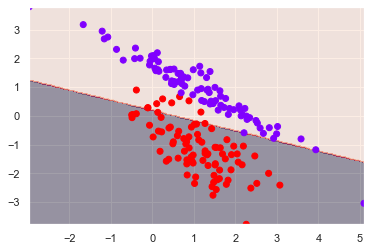

In [10]:
model = Logit(0, 0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

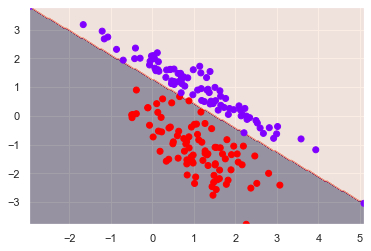

In [11]:
modelLearn = Logit(0, 0, 5)
y[y == 0] = -1
modelLearn.fit(X, y)
plot_decision_boundary(modelLearn, X, y)

```В модели использована roc кривая для определения трешхолда интерпретации вероятности, вроде в целом разделение выглядит обоснованно. При этом если выставить нормальный лернинг рейт, то в принципе все очень хорошо разделяется.```<br/>

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

<function matplotlib.pyplot.show(close=None, block=None)>

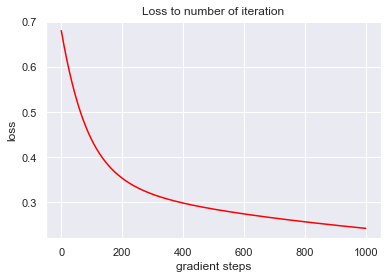

In [12]:
plt.plot(model.loss_history, color = 'red')
plt.title('Loss to number of iteration')
plt.ylabel("loss")
plt.xlabel("gradient steps")
plt.show

```Лосс падает постепенно к 1000 шагам почти до 0```<br/>

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

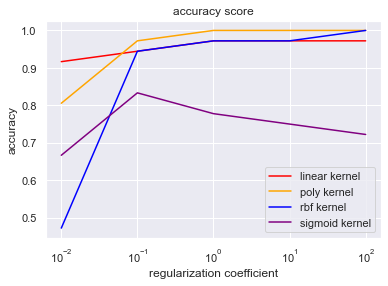

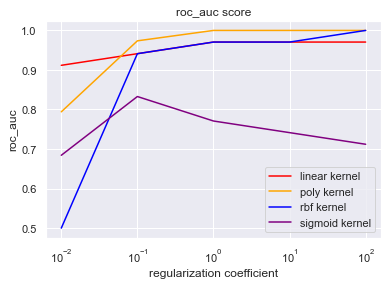

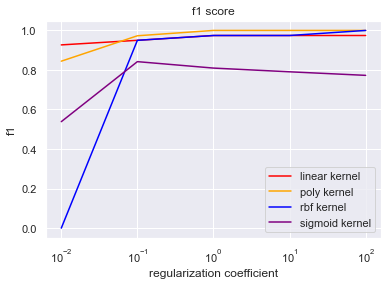

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

lin001 =  SVC(kernel = 'linear', C = 0.01)
lin01 =  SVC(kernel = 'linear', C = 0.1)
lin1 =  SVC(kernel = 'linear', C = 1)
lin10 =  SVC(kernel = 'linear', C = 10)
lin100 =  SVC(kernel = 'linear', C = 100)

pol001 =  SVC(kernel = 'poly', C = 0.01)
pol01 =  SVC(kernel = 'poly', C = 0.1)
pol1 =  SVC(kernel = 'poly', C = 1)
pol10 =  SVC(kernel = 'poly', C = 10)
pol100 =  SVC(kernel = 'poly', C = 100)

rbf001 =  SVC(kernel = 'rbf', C = 0.01)
rbf01 =  SVC(kernel = 'rbf', C = 0.1)
rbf1 =  SVC(kernel = 'rbf', C = 1)
rbf10 =  SVC(kernel = 'rbf', C = 10)
rbf100 =  SVC(kernel = 'rbf', C = 100)

sig001 =  SVC(kernel = 'sigmoid', C = 0.01)
sig01 =  SVC(kernel = 'sigmoid', C = 0.1)
sig1 =  SVC(kernel = 'sigmoid', C = 1)
sig10 =  SVC(kernel = 'sigmoid', C = 10)
sig100 =  SVC(kernel = 'sigmoid', C = 100)

lin001.fit(X_train, y_train)
lin01.fit(X_train, y_train)
lin1.fit(X_train, y_train)
lin10.fit(X_train, y_train)
lin100.fit(X_train, y_train)

pol001.fit(X_train, y_train)
pol01.fit(X_train, y_train)
pol1.fit(X_train, y_train)
pol10.fit(X_train, y_train)
pol100.fit(X_train, y_train)

rbf001.fit(X_train, y_train)
rbf01.fit(X_train, y_train)
rbf1.fit(X_train, y_train)
rbf10.fit(X_train, y_train)
rbf100.fit(X_train, y_train)

sig001.fit(X_train, y_train)
sig01.fit(X_train, y_train)
sig1.fit(X_train, y_train)
sig10.fit(X_train, y_train)
sig100.fit(X_train, y_train)

pred_lin001 = lin001.predict(X_test)
pred_lin01 = lin01.predict(X_test)
pred_lin1 = lin1.predict(X_test)
pred_lin10 = lin10.predict(X_test)
pred_lin100 = lin100.predict(X_test)

pred_pol001 = pol001.predict(X_test)
pred_pol01 = pol01.predict(X_test)
pred_pol1 = pol1.predict(X_test)
pred_pol10 = pol10.predict(X_test)
pred_pol100 = pol100.predict(X_test)

pred_rbf001 = rbf001.predict(X_test)
pred_rbf01 = rbf01.predict(X_test)
pred_rbf1 = rbf1.predict(X_test)
pred_rbf10 = rbf10.predict(X_test)
pred_rbf100 = rbf100.predict(X_test)

pred_sig001 = sig001.predict(X_test)
pred_sig01 = sig01.predict(X_test)
pred_sig1 = sig1.predict(X_test)
pred_sig10 = sig10.predict(X_test)
pred_sig100 = sig100.predict(X_test)

acc_lin001 = accuracy_score(y_test, pred_lin001)
acc_lin01 = accuracy_score(y_test, pred_lin01)
acc_lin1 = accuracy_score(y_test, pred_lin1)
acc_lin10 = accuracy_score(y_test, pred_lin10)
acc_lin100 = accuracy_score(y_test, pred_lin100)

acc_pol001 = accuracy_score(y_test, pred_pol001)
acc_pol01 = accuracy_score(y_test, pred_pol01)
acc_pol1 = accuracy_score(y_test, pred_pol1)
acc_pol10 = accuracy_score(y_test, pred_pol10)
acc_pol100 = accuracy_score(y_test, pred_pol100)

acc_rbf001 = accuracy_score(y_test, pred_rbf001)
acc_rbf01 = accuracy_score(y_test, pred_rbf01)
acc_rbf1 = accuracy_score(y_test, pred_rbf1)
acc_rbf10 = accuracy_score(y_test, pred_rbf10)
acc_rbf100 = accuracy_score(y_test, pred_rbf100)

acc_sig001 = accuracy_score(y_test, pred_sig001)
acc_sig01 = accuracy_score(y_test, pred_sig01)
acc_sig1 = accuracy_score(y_test, pred_sig1)
acc_sig10 = accuracy_score(y_test, pred_sig10)
acc_sig100 = accuracy_score(y_test, pred_sig100)

acc_lin = np.array([acc_lin001, acc_lin01, acc_lin1, acc_lin10, acc_lin100])
acc_pol = np.array([acc_pol001, acc_pol01, acc_pol1, acc_pol10, acc_pol100])
acc_rbf = np.array([acc_rbf001, acc_rbf01, acc_rbf1, acc_rbf10, acc_rbf100])
acc_sig = np.array([acc_sig001, acc_sig01, acc_sig1, acc_sig10, acc_sig100])

roc_lin001 = roc_auc_score(y_test, pred_lin001)
roc_lin01 = roc_auc_score(y_test, pred_lin01)
roc_lin1 = roc_auc_score(y_test, pred_lin1)
roc_lin10 = roc_auc_score(y_test, pred_lin10)
roc_lin100 = roc_auc_score(y_test, pred_lin100)

roc_pol001 = roc_auc_score(y_test, pred_pol001)
roc_pol01 = roc_auc_score(y_test, pred_pol01)
roc_pol1 = roc_auc_score(y_test, pred_pol1)
roc_pol10 = roc_auc_score(y_test, pred_pol10)
roc_pol100 = roc_auc_score(y_test, pred_pol100)

roc_rbf001 = roc_auc_score(y_test, pred_rbf001)
roc_rbf01 = roc_auc_score(y_test, pred_rbf01)
roc_rbf1 = roc_auc_score(y_test, pred_rbf1)
roc_rbf10 = roc_auc_score(y_test, pred_rbf10)
roc_rbf100 = roc_auc_score(y_test, pred_rbf100)

roc_sig001 = roc_auc_score(y_test, pred_sig001)
roc_sig01 = roc_auc_score(y_test, pred_sig01)
roc_sig1 = roc_auc_score(y_test, pred_sig1)
roc_sig10 = roc_auc_score(y_test, pred_sig10)
roc_sig100 = roc_auc_score(y_test, pred_sig100)

roc_lin = np.array([roc_lin001, roc_lin01, roc_lin1, roc_lin10, roc_lin100])
roc_pol = np.array([roc_pol001, roc_pol01, roc_pol1, roc_pol10, roc_pol100])
roc_rbf = np.array([roc_rbf001, roc_rbf01, roc_rbf1, roc_rbf10, roc_rbf100])
roc_sig = np.array([roc_sig001, roc_sig01, roc_sig1, roc_sig10, roc_sig100])

f1_lin001 = f1_score(y_test, pred_lin001)
f1_lin01 = f1_score(y_test, pred_lin01)
f1_lin1 = f1_score(y_test, pred_lin1)
f1_lin10 = f1_score(y_test, pred_lin10)
f1_lin100 = f1_score(y_test, pred_lin100)

f1_pol001 = f1_score(y_test, pred_pol001)
f1_pol01 = f1_score(y_test, pred_pol01)
f1_pol1 = f1_score(y_test, pred_pol1)
f1_pol10 = f1_score(y_test, pred_pol10)
f1_pol100 = f1_score(y_test, pred_pol100)

f1_rbf001 = f1_score(y_test, pred_rbf001)
f1_rbf01 = f1_score(y_test, pred_rbf01)
f1_rbf1 = f1_score(y_test, pred_rbf1)
f1_rbf10 = f1_score(y_test, pred_rbf10)
f1_rbf100 = f1_score(y_test, pred_rbf100)

f1_sig001 = f1_score(y_test, pred_sig001)
f1_sig01 = f1_score(y_test, pred_sig01)
f1_sig1 = f1_score(y_test, pred_sig1)
f1_sig10 = f1_score(y_test, pred_sig10)
f1_sig100 = f1_score(y_test, pred_sig100)

f1_lin = np.array([f1_lin001, f1_lin01, f1_lin1, f1_lin10, f1_lin100])
f1_pol = np.array([f1_pol001, f1_pol01, f1_pol1, f1_pol10, f1_pol100])
f1_rbf = np.array([f1_rbf001, f1_rbf01, f1_rbf1, f1_rbf10, f1_rbf100])
f1_sig = np.array([f1_sig001, f1_sig01, f1_sig1, f1_sig10, f1_sig100])

plt.plot([0.01, 0.1, 1, 10, 100], acc_lin, label='linear kernel', color = 'red')
plt.plot([0.01, 0.1, 1, 10, 100], acc_pol, label='poly kernel', color = 'orange')
plt.plot([0.01, 0.1, 1, 10, 100], acc_rbf, label='rbf kernel', color = 'blue')
plt.plot([0.01, 0.1, 1, 10, 100], acc_sig, label='sigmoid kernel', color = 'purple')
plt.xscale("log")
plt.title("accuracy score")
plt.ylabel("accuracy")
plt.xlabel("regularization coefficient")
plt.legend()
plt.show()

plt.plot([0.01, 0.1, 1, 10, 100], roc_lin, label='linear kernel', color = 'red')
plt.plot([0.01, 0.1, 1, 10, 100], roc_pol, label='poly kernel', color = 'orange')
plt.plot([0.01, 0.1, 1, 10, 100], roc_rbf, label='rbf kernel', color = 'blue')
plt.plot([0.01, 0.1, 1, 10, 100], roc_sig, label='sigmoid kernel', color = 'purple')
plt.xscale("log")
plt.title("roc_auc score")
plt.ylabel("roc_auc")
plt.xlabel("regularization coefficient")
plt.legend()
plt.show()

plt.plot([0.01, 0.1, 1, 10, 100], f1_lin, label='linear kernel', color = 'red')
plt.plot([0.01, 0.1, 1, 10, 100], f1_pol, label='poly kernel', color = 'orange')
plt.plot([0.01, 0.1, 1, 10, 100], f1_rbf, label='rbf kernel', color = 'blue')
plt.plot([0.01, 0.1, 1, 10, 100], f1_sig, label='sigmoid kernel', color = 'purple')
plt.xscale("log")
plt.title("f1 score")
plt.ylabel("f1")
plt.xlabel("regularization coefficient")
plt.legend()
plt.show()

```Выводы ```<br/>
```Итак графики для трех метрик точности. Как можно видеть, все они выглядят примерно одинаково.```<br/>
```Расмотрены линейное, полиномиальное, сигмоидальное и rbf ядро, значения коэффициента регуляризации 0.01, 0.1, 1, 10 и 100```<br/>
```По оси х отложены значения коэффициента регуляризации, а по оси у - метрики точности, примерно до c = 10**-1 точность еще сильно растет, после же уже практически не меняется (за исключением сигмоидального ядра, у которого она начинает падать)```<br/>
```В целом у линейного и поли ядер точность сразу выше, у rbf же она начинается от 0 и сильно растет, доходя до стабильных результатов линейного и поли ядер где-то к 0.1. Сигмоидальное ядро начинает из середины, не дорастает и потом падает, показывая, в целом, самые худшие результаты.```<br/>

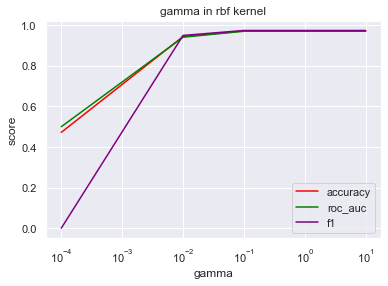

In [14]:
rbfgamma00001 =  SVC(kernel = 'rbf', C = 1, gamma = 0.0001)
rbfgamma001 =  SVC(kernel = 'rbf', C = 1, gamma = 0.01)
rbfgamma01 =  SVC(kernel = 'rbf', C = 1, gamma = 0.1)
rbfgamma10 =  SVC(kernel = 'rbf', C = 1, gamma = 10)

rbfgamma00001.fit(X_train, y_train)
rbfgamma001.fit(X_train, y_train)
rbfgamma01.fit(X_train, y_train)
rbfgamma10.fit(X_train, y_train)

pred_rbfgamma00001 = rbfgamma00001.predict(X_test)
pred_rbfgamma001 = rbfgamma001.predict(X_test)
pred_rbfgamma01 = rbfgamma01.predict(X_test)
pred_rbfgamma10 = rbfgamma10.predict(X_test)

acc_rbfgamma00001 = accuracy_score(y_test, pred_rbfgamma00001)
acc_rbfgamma001 = accuracy_score(y_test, pred_rbfgamma001)
acc_rbfgamma01 = accuracy_score(y_test, pred_rbfgamma01)
acc_rbfgamma10 = accuracy_score(y_test, pred_rbfgamma10)

roc_rbfgamma00001 = roc_auc_score(y_test, pred_rbfgamma00001)
roc_rbfgamma001 = roc_auc_score(y_test, pred_rbfgamma001)
roc_rbfgamma01 = roc_auc_score(y_test, pred_rbfgamma01)
roc_rbfgamma10 = roc_auc_score(y_test, pred_rbfgamma10)

f1_rbfgamma00001 = f1_score(y_test, pred_rbfgamma00001)
f1_rbfgamma001 = f1_score(y_test, pred_rbfgamma001)
f1_rbfgamma01 = f1_score(y_test, pred_rbfgamma01)
f1_rbfgamma10 = f1_score(y_test, pred_rbfgamma10)

acc_gamma = np.array([acc_rbfgamma00001, acc_rbfgamma001, acc_rbfgamma01, acc_rbfgamma10])
roc_gamma = np.array([roc_rbfgamma00001, roc_rbfgamma001, roc_rbfgamma01, roc_rbfgamma10])
f1_gamma = np.array([f1_rbfgamma00001, f1_rbfgamma001, f1_rbfgamma01, f1_rbfgamma10])

plt.plot([0.0001, 0.01, 0.1, 10], acc_gamma, label = 'accuracy', color = 'red')
plt.plot([0.0001, 0.01, 0.1, 10], roc_gamma, label = 'roc_auc',color = 'green')
plt.plot([0.0001, 0.01, 0.1, 10], f1_gamma, label = 'f1',color = 'purple')

plt.xscale("log")
plt.title("gamma in rbf kernel")
plt.ylabel("score")
plt.xlabel("gamma")
plt.legend()
plt.show()

```Выводы ```<br/>
```Это график для анализа влияния гиперпараметра гамма на ядро rbf, как можно видеть при гамме меньше 0.02 точность еще не доходит до единицы, а растет, после же почти не изменяется уравниваясь с 1.```<br/>
```В целом можно сделать вывод, что ядро rbf чувствительно к гиперпараметру гамма.```<br/>

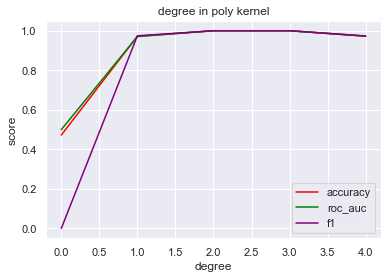

In [15]:
poldeg0 =  SVC(kernel = 'poly', C = 1, degree = 0)
poldeg1 =  SVC(kernel = 'poly', C = 1, degree = 1)
poldeg2 =  SVC(kernel = 'poly', C = 1, degree = 2)
poldeg3 =  SVC(kernel = 'poly', C = 1, degree = 3)
poldeg4 =  SVC(kernel = 'poly', C = 1, degree = 4)

poldeg0.fit(X_train, y_train)
poldeg1.fit(X_train, y_train)
poldeg2.fit(X_train, y_train)
poldeg3.fit(X_train, y_train)
poldeg4.fit(X_train, y_train)

pred_poldeg0 = poldeg0.predict(X_test)
pred_poldeg1 = poldeg1.predict(X_test)
pred_poldeg2 = poldeg2.predict(X_test)
pred_poldeg3 = poldeg3.predict(X_test)
pred_poldeg4 = poldeg4.predict(X_test)

acc_poldeg0 = accuracy_score(y_test, pred_poldeg0)
acc_poldeg1 = accuracy_score(y_test, pred_poldeg1)
acc_poldeg2 = accuracy_score(y_test, pred_poldeg2)
acc_poldeg3 = accuracy_score(y_test, pred_poldeg3)
acc_poldeg4 = accuracy_score(y_test, pred_poldeg4)

roc_poldeg0 = roc_auc_score(y_test, pred_poldeg0)
roc_poldeg1 = roc_auc_score(y_test, pred_poldeg1)
roc_poldeg2 = roc_auc_score(y_test, pred_poldeg2)
roc_poldeg3 = roc_auc_score(y_test, pred_poldeg3)
roc_poldeg4 = roc_auc_score(y_test, pred_poldeg4)

f1_poldeg0 = f1_score(y_test, pred_poldeg0)
f1_poldeg1 = f1_score(y_test, pred_poldeg1)
f1_poldeg2 = f1_score(y_test, pred_poldeg2)
f1_poldeg3 = f1_score(y_test, pred_poldeg3)
f1_poldeg4 = f1_score(y_test, pred_poldeg4)

acc_degree = np.array([acc_poldeg0, acc_poldeg1, acc_poldeg2, acc_poldeg3, acc_poldeg4])
roc_degree = np.array([roc_poldeg0, roc_poldeg1, roc_poldeg2, roc_poldeg3, roc_poldeg4])
f1_degree = np.array([f1_poldeg0, f1_poldeg1, f1_poldeg2, f1_poldeg3, f1_poldeg4])

plt.plot([0, 1, 2, 3, 4], acc_degree, label = 'accuracy', color = 'red')
plt.plot([0, 1, 2, 3, 4], roc_degree, label = 'roc_auc', color = 'green')
plt.plot([0, 1, 2, 3, 4], f1_degree, label = 'f1', color = 'purple')

plt.title("degree in poly kernel")
plt.ylabel("score")
plt.xlabel("degree")
plt.legend()
plt.show()

```Выводы ```<br/>
```Это график для анализа влияния гиперпараметра degree на поли ядро, как можно видеть при парамтре меньше 1 точность еще не доходит до единицы, а растет, после же почти не изменяется уравниваясь с 1.```<br/>
```В целом можно сделать вывод, что поли ядро чувствительно к гиперпараметру degree.```<br/>

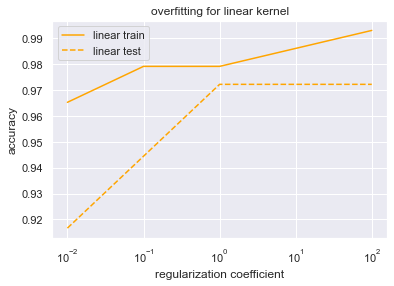

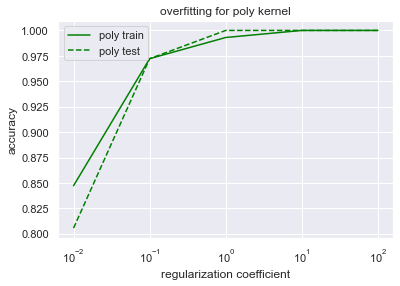

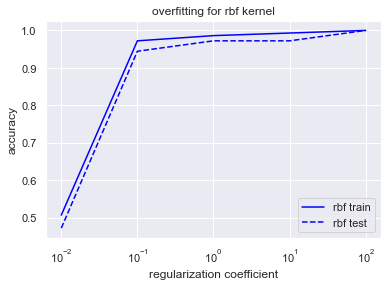

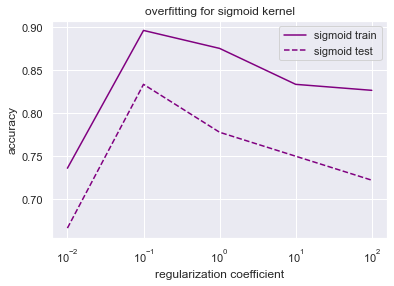

In [16]:
pred_sig_train001 = sig001.predict(X_train)
pred_sig_train01 = sig01.predict(X_train)
pred_sig_train1 = sig1.predict(X_train)
pred_sig_train10 = sig10.predict(X_train)
pred_sig_train100 = sig100.predict(X_train)

pred_lin_train001 = lin001.predict(X_train)
pred_lin_train01 = lin01.predict(X_train)
pred_lin_train1 = lin1.predict(X_train)
pred_lin_train10 = lin10.predict(X_train)
pred_lin_train100 = lin100.predict(X_train)

pred_pol_train001 = pol001.predict(X_train)
pred_pol_train01 = pol01.predict(X_train)
pred_pol_train1 = pol1.predict(X_train)
pred_pol_train10 = pol10.predict(X_train)
pred_pol_train100 = pol100.predict(X_train)

pred_rbf_train001 = rbf001.predict(X_train)
pred_rbf_train01 = rbf01.predict(X_train)
pred_rbf_train1 = rbf1.predict(X_train)
pred_rbf_train10 = rbf10.predict(X_train)
pred_rbf_train100 = rbf100.predict(X_train)

acc_lin_train001 = accuracy_score(y_train, pred_lin_train001)
acc_lin_train01 = accuracy_score(y_train, pred_lin_train01)
acc_lin_train1 = accuracy_score(y_train, pred_lin_train1)
acc_lin_train10 = accuracy_score(y_train, pred_lin_train10)
acc_lin_train100 = accuracy_score(y_train, pred_lin_train100)

acc_pol_train001 = accuracy_score(y_train, pred_pol_train001)
acc_pol_train01 = accuracy_score(y_train, pred_pol_train01)
acc_pol_train1 = accuracy_score(y_train, pred_pol_train1)
acc_pol_train10 = accuracy_score(y_train, pred_pol_train10)
acc_pol_train100 = accuracy_score(y_train, pred_pol_train100)

acc_rbf_train001 = accuracy_score(y_train, pred_rbf_train001)
acc_rbf_train01 = accuracy_score(y_train, pred_rbf_train01)
acc_rbf_train1 = accuracy_score(y_train, pred_rbf_train1)
acc_rbf_train10 = accuracy_score(y_train, pred_rbf_train10)
acc_rbf_train100 = accuracy_score(y_train, pred_rbf_train100)

acc_sig_train001 = accuracy_score(y_train, pred_sig_train001)
acc_sig_train01 = accuracy_score(y_train, pred_sig_train01)
acc_sig_train1 = accuracy_score(y_train, pred_sig_train1)
acc_sig_train10 = accuracy_score(y_train, pred_sig_train10)
acc_sig_train100 = accuracy_score(y_train, pred_sig_train100)

acc_sig_train = np.array([acc_sig_train001, acc_sig_train01, acc_sig_train1, acc_sig_train10, acc_sig_train100])
acc_lin_train = np.array([acc_lin_train001, acc_lin_train01, acc_lin_train1, acc_lin_train10, acc_lin_train100])
acc_pol_train = np.array([acc_pol_train001, acc_pol_train01, acc_pol_train1, acc_pol_train10, acc_pol_train100])
acc_rbf_train = np.array([acc_rbf_train001, acc_rbf_train01, acc_rbf_train1, acc_rbf_train10, acc_rbf_train100])

plt.plot([0.01, 0.1, 1, 10, 100], acc_lin_train, label='linear train', color = 'orange')
plt.plot([0.01, 0.1, 1, 10, 100], acc_lin, linestyle = 'dashed', label = 'linear test', color = 'orange')
plt.xscale("log")
plt.title("overfitting for linear kernel")
plt.ylabel("accuracy")
plt.xlabel("regularization coefficient")
plt.legend()
plt.show()

plt.plot([0.01, 0.1, 1, 10, 100], acc_pol_train, label='poly train', color = 'green')
plt.plot([0.01, 0.1, 1, 10, 100], acc_pol, linestyle = 'dashed', label = 'poly test', color = 'green')
plt.xscale("log")
plt.title("overfitting for poly kernel")
plt.ylabel("accuracy")
plt.xlabel("regularization coefficient")
plt.legend()
plt.show()

plt.plot([0.01, 0.1, 1, 10, 100], acc_rbf_train, label='rbf train', color = 'blue')
plt.plot([0.01, 0.1, 1, 10, 100], acc_rbf, linestyle = 'dashed', label = 'rbf test', color = 'blue')
plt.xscale("log")
plt.title("overfitting for rbf kernel")
plt.ylabel("accuracy")
plt.xlabel("regularization coefficient")
plt.legend()
plt.show()

plt.plot([0.01, 0.1, 1, 10, 100], acc_sig_train, label='sigmoid train', color = 'purple')
plt.plot([0.01, 0.1, 1, 10, 100], acc_sig, linestyle = 'dashed', label = 'sigmoid test', color = 'purple')
plt.xscale("log")
plt.title("overfitting for sigmoid kernel")
plt.ylabel("accuracy")
plt.xlabel("regularization coefficient")
plt.legend()
plt.show()

```Выводы ```<br/>
~~я не могу больше это делать~~<br/>
```Это анализ того, какое из ядер скорее склонно к оверфиттингу.```<br/>
```Так как оверфиттинг - это переобучение, при котором точность на трейне выше, чем на тесте, на графиках это будет соответствовать ситуации, когда сплошная линия на графике выше прерывистой```<br/>
```Здесь получается, что оверфиттинг довольно большой у сигмоидального и линейного ядер (у линейного меньше всего при параметре регуляризации равном 1, у сигмоидального - до 0.1).```<br/>
```У поли ядра и rbf ядра линии почти равны, что говорит о наименьшем оверфиттинге, в поли ядре линия теста даже на какой-то миг выходит наверх, то есть точность на тесте выше, чем на трейне - это скорее всего случайность, но в любом случае приятная случайность.```<br/>
```Можно сказать, что наиболее склонно к оверфиттингу сигмоидальное ядро, после него - линейное, далее довольно хорошие результаты показывают rbf и поли ядра.```<br/>

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: [0.5 point]
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset  [1.5 point]
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

```Выбранные авторы: Брюсов, Чехов, Достоевский, Гоголь, Горький, Тургенев```<br/>
```Надеюсь, что у проверяющих папка prose будет лежать там же...```<br/>

In [17]:
import os
import re
import random

authors = []

for author in os.listdir("prose"):
    name = ""
    if "Chekhov" in author:
        name = "Чехов"
    elif  "Bryusov" in author:
        name = "Брюсов"
    elif "Dostoevsky" in author:
        name = "Достоевский"
    elif "Gogol" in author:
        name = "Гоголь"
    elif "Gorky" in author: 
        name = "Горький"
    elif "Turgenev" in author:
        name = "Тургенев"
        
    if name == "":
        continue
        
    lines = []
    
    for filename in os.listdir("prose/"+author):
        if filename.endswith(".txt"):
            for line in open("prose/"+author+"/"+filename, encoding="utf-8"):
                lines.append(line)
    collection = re.sub(r'\s+', ' ' ,' '.join(lines))
    
    authors.append(np.array([collection, name]))
len(authors)

6

```Алилуйя у нас есть большой массив со всеми текстами.``` <br/>
```Теперь разобъем тексты на предложения и возьмем из них  15k, 7k, 30k, 20k, 40k, 3k предложений соответственно из сочинений Брюсова, Чехова, Достоевского, Гоголя, Горького и Тургенева (в таком порядке, потому что у некоторых авторов меньше, чем 30к и 40к предложений.)```<br/>

In [18]:
random.seed(6)

allsentences = []
allauthors = []

for line in authors:
    sentences = re.split(r'(?<=[.?!…])(?: [–—])? (?=«?[A-ZА-ЯЁÀ-Ý][a-zа-яёà-ÿ]*)', line[0])
    bigsent = [sent for sent in sentences if len(sent.strip()) >= 15]
    
    num_taken = 0
    
    if line[1] == "Брюсов":
        num_taken = 15000
    elif line[1] == "Чехов":
        num_taken = 7000
    elif line[1] == "Достоевский":
        num_taken = 30000
    elif line[1] == "Гоголь":
        num_taken = 20000
    elif line[1] == "Горький":
        num_taken = 40000   
    elif line[1] == "Тургенев":
        num_taken = 3000
        
    sent_taken = random.sample(bigsent, num_taken)
    
    allsentences.extend(sent_taken)
    allauthors.extend(np.full(len(sent_taken), line[1]))
    print(f'{line[1]} было {len(bigsent)} предложений, взяли {len(sent_taken)}')      
    
data = pd.DataFrame({'sentence' : allsentences, 'author' : allauthors})

print("\n")
print(data.info())
data.head(10)

Брюсов было 22018 предложений, взяли 15000
Чехов было 23776 предложений, взяли 7000
Достоевский было 104171 предложений, взяли 30000
Гоголь было 21304 предложений, взяли 20000
Горький было 47380 предложений, взяли 40000
Тургенев было 25000 предложений, взяли 3000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115000 entries, 0 to 114999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  115000 non-null  object
 1   author    115000 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None


,sentence,author
0,"В толпе женщин, выходивших вместе с нами после...",Брюсов
1,Должно воспользоваться им немедленно.,Брюсов
2,А дни проходили.,Брюсов
3,"Родители мои еще до моего рождения порешили, ч...",Брюсов
4,"Но я, все стоя на коленях, продолжал говорить ...",Брюсов
5,Рим -- это в сокращении мир.,Брюсов
6,"Одни были заняты домашними работами, другие ук...",Брюсов
7,"Флавиан откровенно сообщил всем, что император...",Брюсов
8,"Торжествуй, -- ты обманул меня, прикинувшись б...",Брюсов
9,"Внезапно, когда я уже сознавал себя победителе...",Брюсов


```ИТАК у нас есть датафрейм, не прошло честно говоря и полночи. Здесь мы уже выбросили все предложения короче 15 символов и выбрали из авторов рандомно нужные пропорции предложений. Осталась остальная обработка....```<br/>
```По причинам понимаемости происходящего я буду использовать для этого инструменты, использованные в семинаре 6```<br/><br/>
```ВРЕМЯ ПРЕПРОЦЕССИНГА```<br/>

In [19]:
import string
import nltk
!pip install pymorphy2
import pymorphy2

nltk.download('stopwords')
word_tokenizer = nltk.WordPunctTokenizer()
lemmatizer = pymorphy2.MorphAnalyzer()

stop_words = nltk.corpus.stopwords.words('russian')
punct = string.punctuation
punct += "—--...…!«!»?«?»«,»,)."
digits = string.digits

lemm_column = []

for sent in data["sentence"]:
    to_lower = sent.lower()
    tokens = word_tokenizer.tokenize(to_lower)
    tokens = [word for word in tokens if (word not in punct and word not in stop_words and word not in digits)]
    lems = []
    for word in tokens:
        lemm = lemmatizer.parse(word)[0].normal_form
        lems.append(lemm)
    
    lemm_column.append(' '.join(lems))
data.insert(2, 'lemmas', lemm_column)
data.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Natalya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,sentence,author,lemmas
0,"В толпе женщин, выходивших вместе с нами после...",Брюсов,толпа женщина выходить вместе мы шесть час сте...
1,Должно воспользоваться им немедленно.,Брюсов,должный воспользоваться немедленно
2,А дни проходили.,Брюсов,день проходить
3,"Родители мои еще до моего рождения порешили, ч...",Брюсов,родитель мой мой рождение порешить первенец не...
4,"Но я, все стоя на коленях, продолжал говорить ...",Брюсов,стоя колено продолжать говорить безумие властн...
5,Рим -- это в сокращении мир.,Брюсов,рим это сокращение мир
6,"Одни были заняты домашними работами, другие ук...",Брюсов,один занятый домашний работа другой укладывать...
7,"Флавиан откровенно сообщил всем, что император...",Брюсов,флавиан откровенно сообщить весь император фео...
8,"Торжествуй, -- ты обманул меня, прикинувшись б...",Брюсов,торжествовать обмануть прикинуться больший дос...
9,"Внезапно, когда я уже сознавал себя победителе...",Брюсов,внезапно сознавать победитель сопротивление ре...


```Теперь у нас есть леммы в лоуэркейсе без чисел, знаков препинания и стоп-слов. Пора векторизовать…```<br/>

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

bag_vectorizer = CountVectorizer(max_features = 5000)
tf_vectorizer = TfidfVectorizer(max_features = 5000)

bag_vectorizer.fit(data["lemmas"])
tf_vectorizer.fit(data["lemmas"])

#print(f'100 most common in bag of words {bag_vectorizer.get_feature_names()}')
#print(f'100 most common in tf-idf {tf_vectorizer.get_feature_names()}')

bag_result  = bag_vectorizer.transform(data["lemmas"])
tf_result = tf_vectorizer.transform(data["lemmas"])

In [23]:
#print(data["lemmas"][3])
#print(f'\nexample of bag of words results {bag_result.todense()[3]}')
#print(f'\nexample of tf-idf results {tf_result.todense()[3]}')

In [24]:
dense_bag = np.asarray(bag_result.todense())
dense_tf = np.asarray(tf_result.todense())

data.insert(3, 'bag results', [dense_bag[i] for i in range(dense_bag.shape[0])])
data.insert(4, 'tf-idf results', [dense_tf[i] for i in range(dense_tf.shape[0])])

```UPD тут вывод про векторизацию на 100 слов, я решила что возможно точность улучшиться, если взять больше фич, поэтому их будет 5000, но выводить их все (это ужасно много) и анализировать детально мне не хочется, а прошлый вывод был довольно неплох, поэтому прошлый комментарий удалять не буду```<br/><br/>```Можно посмотреть на результаты векторизации.```<br/>
```При взгляде на 100 самых частых слов (которые затем и выбираются для фичерз) видно, что методы ожидаемо вычислили частые слова одинаково. Дальше отличается то, как именно численно выражается каждая строка. ```<br/>
```Для bag of words стоит только количество, соответствующее числу вхождений леммы. Так, при выводе результата для предложения с индексом 3 мы видим число 2, соответствующее тому, что в то предложение лемма "мой" входит дважды (лемма находится на том же индексе в топ100 как и двойка в этом массиве).```<br/>
```Для tf-idf числа означают важность слова, то есть число его вхождений в предложение делится на частоту предложений, которые его содержат (логарифмируемое) в общем наборе предложений. Это позволяет учитывать частые уникальные для текста слова с большим весом, чем частые в принципе слова. То есть слово "мой" входит с весом около 0.8 - его два, при этом оно``` ~~примерно посередине встречаемости~~```(я осознала, что фичи упорядочены по алфавиту, а не по частоте, так что позиция в списке не имеет смысла). ```<br/>
```Но кажется для слов, которые входят в фичи и при этом в предложении встречаются 1 раз (как "год" и "человек") вес около 0.4, поэтому логично, что у слова "мой", дробь с обратной частотой которого наверное сравнимая с дробью для слов "год" и "человек", вес в 2 раза больше обычного, потому что слово входит в предложение дважды.```<br/><br/>
```Короче, tf-idf, как и можно было ожидать, - более тонкая метрика, однако ее результаты чуть менее наглядны, чем в bag of words.```<br/>

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. [1 point]
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. [1 point]
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

**HINT:** In the task 8.2 you should analyze models for binary classification task. How do you think the AUC_ROC should be high? Is the 0.6 enough for us?

In [25]:
from sklearn.model_selection import cross_val_predict

data_ch = data[(data["author"] == "Чехов")]
data_tu = data[(data["author"] == "Тургенев")]

len_ch = len(data_ch)
len_tu = len(data_tu)

#assert (np.abs(len_gor - len_dos)/min(len_dos, len_gor)) < 0.5

min_len = min(len_ch, len_tu)

if len_ch > len_tu:
    data_ch = data_ch[:min_len]
else:
    data_tu = data_tu[:min_len]
    
assert (len(data_tu) == len(data_ch))

data_two = data_ch.append(data_tu)

In [26]:
y = np.where(data_two["author"] == "Тургенев", -1, 1)

#bag_X_train, bag_X_test, bag_y_train, bag_y_test = train_test_split(np.vstack(data["bag results"]), y, test_size = 0.25, random_state = 0)
tf_X_train, tf_X_test, tf_y_train, tf_y_test = train_test_split(np.vstack(data_two["tf-idf results"]), y, test_size = 0.25, random_state = 0)

log = Logit(0, 0, 5)
svc =  SVC(kernel = 'linear', C = 1)

```Датасет настроен, взяты``` ~~~Достоевский и Горький, проверка на сбалансированность классов: они отличаются менее чем на 50% меньшего из них. На самом деле можно было взять авторов, у которых меньше предложений, потому что тогда время обработки было бы меньше, но тогда разница между объемами датасетов была бы более ощутимой.~~~```Чехов и Тургенев, и Чехов обрезан до 3к предложений, потому что время обработки существенно, а, как сказали, можно обрезать для сбалансированности классов. Так как выборка уже была рандомной, можно просто взять от большего по объему автора первые н в нужном количестве.```<br/>
```Я буду использовать только tf-idf векторизацию, так как она более точная.```

In [27]:
tf_svc_pred = cross_val_predict(svc, tf_X_train, tf_y_train, cv = 5)

In [28]:
tf_log_pred = cross_val_predict(log, tf_X_train, tf_y_train, cv = 5)

~~Желание оратьЭта вещь считалась кажется час~~```Теперь с меньшим датасетом оно считается не час, можно жить.```<br/>
```Опять же непонятно, что именно подразумевалось под train using cross validation. Это кажется самое близкое, однако эта вещь фитит трейнит и предиктит сама и все сразу, поэтому поставить в нее потом тест чтобы получить какие-то параметры для верификации нельзя (ставить просто все я наверное не буду потому что это еще час ждать, пока она посчитает все). Так что будут конфьюжен матрицы для предикшенов по трейновым частям датасета.```<br/>

Precision:   0.69
Recall:   0.68
F1-measure:   0.68
Accuracy:   0.68


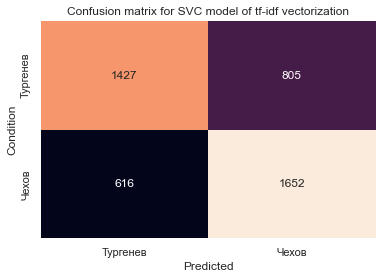

In [29]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

print("Precision: {0:6.2f}".format(precision_score(tf_y_train, tf_svc_pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(tf_y_train, tf_svc_pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(tf_y_train, tf_svc_pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(tf_y_train, tf_svc_pred)))
labels = ['Тургенев','Чехов']
     
sns.heatmap(data=confusion_matrix(tf_y_train, tf_svc_pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix for SVC model of tf-idf vectorization")
plt.ylabel("Condition")
plt.xlabel("Predicted")
plt.show()

```Конфьюжн матрица для модели склерна.```<br/> ```
Показатели в принципе довольно неплохие (roc_auc посчитать не представляется возможным), при этом матрица имеет почти главнодиагональный вид (на фолс позитив и фолс негатив не нули, но все же значения меньшие, чем на главной диагонали.).```<br/>

Precision:   0.64
Recall:   0.64
F1-measure:   0.64
Accuracy:   0.64


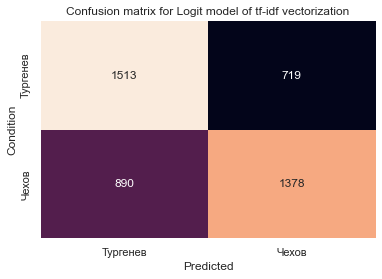

In [30]:
print("Precision: {0:6.2f}".format(precision_score(tf_y_train, tf_log_pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(tf_y_train, tf_log_pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(tf_y_train, tf_log_pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(tf_y_train, tf_log_pred)))
labels = ['Тургенев','Чехов']
     
sns.heatmap(data=confusion_matrix(tf_y_train, tf_log_pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix for Logit model of tf-idf vectorization")
plt.ylabel("Condition")
plt.xlabel("Predicted")
plt.show()

```Конфьюжн матрица для нашей модели логистической регрессии.```<br/> ```
Метрики в принципе сравнимы с результатами библиотечной модели, что не может не радовать, матица тоже практически диагональна, что очень неплохо```<br/><br/>
```Позволю себе теперь потренировать модели и проверить на тестах с помощью обычных фит и предикт без кросс валидации, потому что она сжирает ОЧЕНЬ много времени```

In [31]:
tf_svc_fit = svc.fit(tf_X_train, tf_y_train)
tf_log_fit = log.fit(tf_X_train, tf_y_train)

Precision:   0.68
Accuracy:   0.68
Recall:   0.68
F1-measure:   0.68


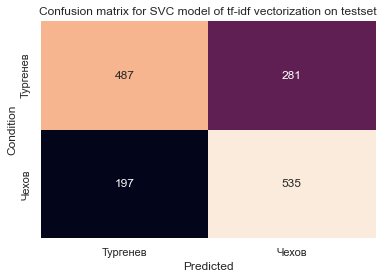

In [32]:
tf_svc_pred_test = tf_svc_fit.predict(tf_X_test)

print("Precision: {0:6.2f}".format(precision_score(tf_y_test, tf_svc_pred_test, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(tf_y_test, tf_svc_pred_test)))
print("Recall: {0:6.2f}".format(recall_score(tf_y_test, tf_svc_pred_test, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(tf_y_test, tf_svc_pred_test, average='macro')))
labels = ['Тургенев','Чехов']
     
sns.heatmap(data=confusion_matrix(tf_y_test, tf_svc_pred_test), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix for SVC model of tf-idf vectorization on testset")
plt.ylabel("Condition")
plt.xlabel("Predicted")
plt.show()

```Вывод для SVC по нормальному обучению и проверке на тесте:```<br/>```
Все значения подозрительно похожи на то, что было на трейне с кросс-валидацией. То есть, видимо, особой разницы нет...```<br/>```
Значение precision, которое показывает долю правильно определенных положительных из всех определенных как положительные, 0.68 говорит о том что в целом мы больше половины определенных тру определяем правильно, то есть у нас не очень много фолс позитив срабатываний, что неплохо.```<br/>```
Значение accuracy отвечает за то, насколько мы верно распознаем тру позитив и негатив суммарно из популяции. Если она равна 0.68 это опять же говорит о том, что больше половины всех объектов распознано верно, пожалуй имеет смысл радоваться.```<br/>```
Recall - это доля правильно распознанных положительных от всех положительных, если она равна 0.68, то можно сказать, что больше половины кондишн позитив мы определяем как позитив.```<br/>```
Оценка f1, гармоническое пресижена и реколла, отвечает за баланс между долей положительных предсказаний в общей популяции и долей корректно распознанных положительных. Ее значение 0.68 показывает, что они достаточно сбалансированны.```<br/>```
В целом кажется это довольно неплохо. Мы хорошо умеем правильно распознавать Чехова, иногда принимаем Тургенева за Чехова, но наоборот - очень редко. В целом, опять же, тру предикшенов больше, чем каких-то еще```<br/>

Precision:   0.63
Accuracy:   0.63
Recall:   0.63
F1-measure:   0.63


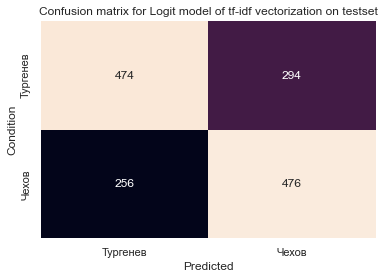

In [33]:
tf_log_pred_test = tf_log_fit.predict(tf_X_test)

print("Precision: {0:6.2f}".format(precision_score(tf_y_test, tf_log_pred_test, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(tf_y_test, tf_log_pred_test)))
print("Recall: {0:6.2f}".format(recall_score(tf_y_test, tf_log_pred_test, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(tf_y_test, tf_log_pred_test, average='macro')))
labels = ['Тургенев','Чехов']
     
sns.heatmap(data=confusion_matrix(tf_y_test, tf_log_pred_test), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix for Logit model of tf-idf vectorization on testset")
plt.ylabel("Condition")
plt.xlabel("Predicted")
plt.show()

```Видно, что матрики практически такие же, как были на трейнес кросс-валидацией, при этом значения больше 0.6, что в целом уже радует чуть больше. Матрица на этот раз чуть более сбалансирована, тру предикшенов поровну, как и фолс между собой.```<br/><br/>```
В целом можно сделать вывод, что наша модель, конечно, хуже библиотечной, но не намного. Метрики сравнимы по значениям, а матрицы выглядят диагонально, в целом довольно неплохой результат.
```<br/><br/><br/>```А ТЕПЕРЬ ПУНКТ 8.2```

In [34]:
from sklearn.model_selection import GridSearchCV
kernels = np.array(["linear", "poly", "rbf"])
cs = np.array([0.01, 1, 100])
         
searcherS = GridSearchCV(SVC(),   param_grid = {"kernel": kernels, "C" : cs}, scoring = "roc_auc", cv = 5)
searcherS.fit(tf_X_train, tf_y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e+00, 1.e+02]),
                         'kernel': array(['linear', 'poly', 'rbf'], dtype='<U6')},
             scoring='roc_auc')

Best kernel = linear
Best c = 1.0


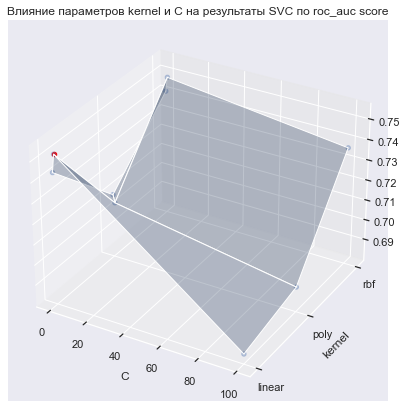

In [54]:
best_kernel = searcherS.best_params_["kernel"]
best_c = searcherS.best_params_["C"]

print(f'Best kernel = {best_kernel}')
print(f'Best c = {best_c}')

resS = np.reshape(searcherS.cv_results_["mean_test_score"], (3,3))

z = resS
y = [[0,1,2],[0,1,2],[0,1,2]]
x = [[cs[0], cs[0], cs[0]],[cs[1], cs[1], cs[1]],[cs[2], cs[2], cs[2]]]
 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection = "3d")

ax.scatter3D(x, y, z, alpha = 0.3)
ax.scatter3D(best_c, 0, np.max(resS), color = "red")
ax.plot_surface(x, y, z, alpha = 0.3)
plt.title("Влияние параметров kernel и C на результаты SVC по roc_auc score")
plt.ylabel("kernel")
ax.set_yticks([0,1,2])
ax.set_yticklabels(["linear", "poly", "rbf"])
plt.xlabel("C")
#plt.zlabel("score")
plt.show()

```Получили значения параметров для SVC: лучшее ядро - линейное, и лучшей коэффициент регуляризации - 1, чему соответствует красная точка на графике. Окей, будем знать. По графику видно, что линейное ядро падает при увеличении С более резко, чем другие, и при этом поли ядро намного хуже других. Но скор здесь в любом случае меняется от 0.69 до 0.75, так что подбор хороших параметров, конечно, важен, но не критичен.```<br/><br/>
```Теперь найдем параметры для нашей модели```

In [36]:
betas = np.array([0.1, 1, 2])
gammas = np.array([0.1, 1, 2])
searcherL = GridSearchCV(Logit(), {"beta": betas, "gamma" : gammas}, scoring = "roc_auc", cv = 5)
searcherL.fit(tf_X_train, tf_y_train)

GridSearchCV(cv=5, estimator=Logit(),
             param_grid={'beta': array([0.1, 1. , 2. ]),
                         'gamma': array([0.1, 1. , 2. ])},
             scoring='roc_auc')

Best beta = 0.1
Best gamma = 2.0


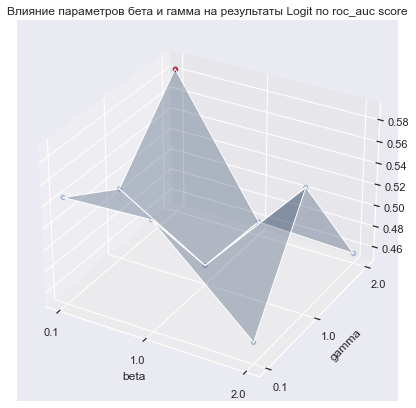

In [37]:
best_beta = searcherL.best_params_["beta"]
best_gamma = searcherL.best_params_["gamma"]

print(f'Best beta = {best_beta}')
print(f'Best gamma = {best_gamma}')
res = np.reshape(searcherL.cv_results_["mean_test_score"], (3,3))
#print(searcherL.cv_results_)

z = res
x = [[betas[0], betas[0], betas[0]],[betas[1], betas[1], betas[1]],[betas[2], betas[2], betas[2]]]
y = [gammas,gammas,gammas]
 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, alpha = 0.3)
ax.scatter3D(best_beta, best_gamma, np.max(res), color = "red")
ax.plot_surface(x, y, z, alpha = 0.3)
ax.set_xticks(betas)
ax.set_yticks(gammas)
plt.title("Влияние параметров бета и гамма на результаты Logit по roc_auc score")
plt.xlabel("beta")
plt.ylabel("gamma")
plt.show()

```Узнали, что лучшая бета - 0.1, а гамма - 2 (это очень смешно, я до этого считала их с векторизацией на 100 фич и значения были ровно наоборот). График для беты и гаммы показывает, что про какие-то однозначные зависимости говорить трудно. Самое большое значение ярко выраженно красной точкой, оно соответствует найденным оптимальным параметрам беты и гаммы. Кажется от центра нижней плоскости в направлении этой точки есть какой-то рост, но он и в другие стороны есть, в целом хаотичный и понять какую-то однозначную зависимость сложно.```

In [38]:
lrs = np.array([1e-2, 1, 5])
tolerances = np.array([1e-9, 1e-8, 1e-7])

iters = np.array([100, 1000, 10000])

searcherL2 = GridSearchCV(Logit(), {"lr": lrs, "tolerance" : tolerances}, scoring = "roc_auc", cv = 5)
searcherLi = GridSearchCV(Logit(), {"max_iter": iters}, scoring = "roc_auc", cv = 5)

searcherL2.fit(tf_X_train, tf_y_train)
searcherLi.fit(tf_X_train, tf_y_train)

GridSearchCV(cv=5, estimator=Logit(),
             param_grid={'max_iter': array([  100,  1000, 10000])},
             scoring='roc_auc')

Best learning rate = 0.01
Best tolerance = 1e-09


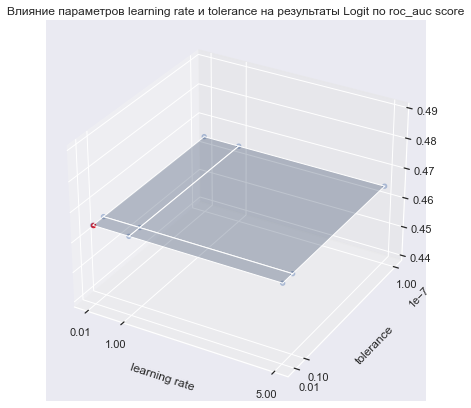

In [39]:
best_lr = searcherL2.best_params_["lr"]
best_tolerance = searcherL2.best_params_["tolerance"]

print(f'Best learning rate = {best_lr}')
print(f'Best tolerance = {best_tolerance}')
res2 = np.reshape(searcherL2.cv_results_["mean_test_score"], (3,3))

z = res2
x = [[lrs[0], lrs[0], lrs[0]],[lrs[1], lrs[1], lrs[1]],[lrs[2], lrs[2], lrs[2]]]
y = [tolerances,tolerances,tolerances]
 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, alpha = 0.3)
ax.plot_surface(x, y, z, alpha = 0.3)
ax.set_xticks(lrs)
ax.set_yticks(tolerances)
ax.scatter3D(best_lr, best_tolerance, np.max(res2), color = "red")
plt.title("Влияние параметров learning rate и tolerance на результаты Logit по roc_auc score")
plt.xlabel("learning rate")
plt.ylabel("tolerance")
#plt.zlabel("score")
plt.show()

```Очень антикульминативный график, оказывается, лернинг рейт и толеранс вообще не влияют на roc_auc, по крайней мере на тех значениях, которые проверялись.```

Best max_iter = 10000


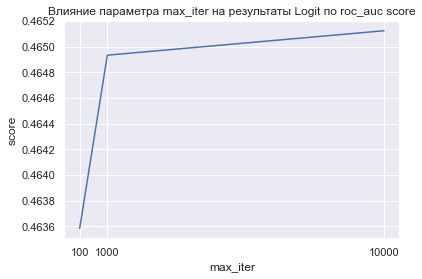

In [40]:
resI = searcherLi.cv_results_["mean_test_score"]

best_iter = searcherLi.best_params_["max_iter"]
print(f'Best max_iter = {best_iter}')

x = iters
y = resI

plt.plot(x, y)
plt.title("Влияние параметра max_iter на результаты Logit по roc_auc score")
plt.xticks(iters)
plt.xlabel("max_iter")
plt.ylabel("score")
plt.show()

```Очень радует этот график, поскольку на запуске на 100 фичах он был ровно такой же, но перевернутый вниз, то есть скор падал при увеличении итераций. Здесь видно, что при увеличении числа итераций от 100 до 1000 скор резко растет, потом же до 10000 увеличивается несущественно. В любом случае он на всем графике меняется на сотые доли, так что вероятнее всего количество итераций не особенно существенно, но оптимальное количество 10000.```<br/><br/>
```Короче, модели неодинаково чувствительны к разным параметрам. При этом там, где чувствительность есть, она бывает очень хаотичная, как в случае с гаммой и бетой, и в любом случае не дает каких-то больших преимуществ, roc_auc все равно нигде не достиг даже 0.6 на нашей модели, что прискорбно, потому что 0.5 сравнимо с просто рандомным угадыванием, что можно было делать и без суперсложных моделей```<br/>
```Зато библиотечная модель в целом лучше но, пожалуй, тоже не очень зависит от параметров, если выбрать худший вариант, можно скор уронить с 0.75 до 0.69, что наверное не очень большая разница.```

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

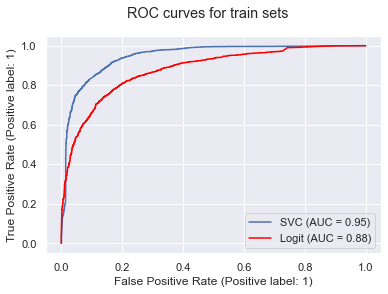

In [41]:
from sklearn.metrics import plot_roc_curve

p1 = plot_roc_curve(svc, tf_X_train, tf_y_train)
p1 = plot_roc_curve(log, tf_X_train, tf_y_train,ax = p1.ax_, color = "red")
p1.figure_.suptitle("ROC curves for train sets")
plt.show() 

```Построим roc кривые для SVC и Logit на трейн наборах данных. Как можно видеть, Logit показывает немного менее хорошие результаты, но в целом обе модели ведут себя достойно.<br/>

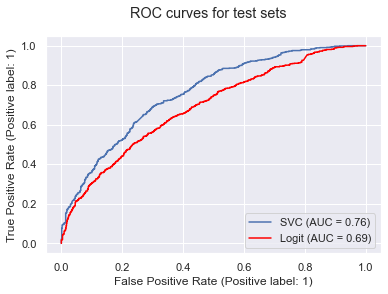

In [42]:
p2 = plot_roc_curve(svc, tf_X_test, tf_y_test)
p2 = plot_roc_curve(log, tf_X_test, tf_y_test,ax = p2.ax_, color = "red")
p2.figure_.suptitle("ROC curves for test sets")
plt.show() 

```Те же кривые для тестовых данных выглядят более плоскими, но все же даже в случае логита это не рандомное угадывание, скор почти 0.7 - это, пожалуй, прилично.```<br/>

fpr is 0.20206093189964158
tpr is 0.8112874779541446
threshold is 0.5058346113793771


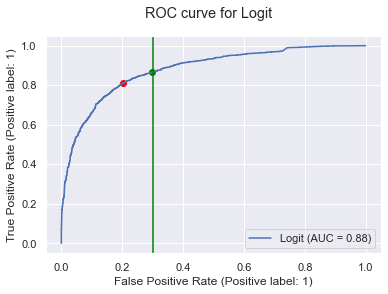


max fpr < 0.3 0.29838709677419356
max tpr with fpr < 0.3 0.8664021164021164


In [43]:
p3 = plot_roc_curve(log, tf_X_train, tf_y_train)
fpr = log.fpr
tpr = log.tpr
ind = np.argmax(tpr - fpr)
th = log.borderline

print(f'fpr is {fpr[ind]}')
print(f'tpr is {tpr[ind]}')
print(f'threshold is {th}')

p3.figure_.suptitle("ROC curve for Logit")
plt.scatter([fpr[ind]], [tpr[ind]], color = "red")
plt.axvline(x=0.3, color = "green")

maxfpr = max(fpr[fpr <= 0.3])
maxtpr = max(tpr[np.where(fpr == maxfpr)])
plt.scatter([maxfpr], [maxtpr], color = "green")
plt.show() 
print(f'\nmax fpr < 0.3 {maxfpr}')
print(f'max tpr with fpr < 0.3 {maxtpr}')

```Теперь посмотрим на roc для Logita на трейне подробнее, конкретно на трешхолды. Красная точка показывает использованные при обучении фпр, тпр и трешхолд (они же выписаны над графиком), тпр там 0.8, что неплохо, фпр 0.2, что вообще круто, она не слишком высокая, трешхолд 0.5 (вот и случилось предсказание классов с сравнением с 0.5).```<br/>
```Если мы хотим ограничить фпр 30 процентами, можем попробовать это сделать. Зеленая линия показывает эту границу, соответственно нас интересует самая высокая по тпр точка левее зеленой линии или на ней. Как написано под графиком и отмечено зеленой точкой, это точка с тпр 0.866 и фпр 0.298. В целом, наверное, можно было бы использовать и этот трешхолд, если бы нам было не так существенно минимизировать фолс позитив.```

fpr is 0.17023134368380125
tpr is 0.7839643615828155
threshold is 0.14816186999330577


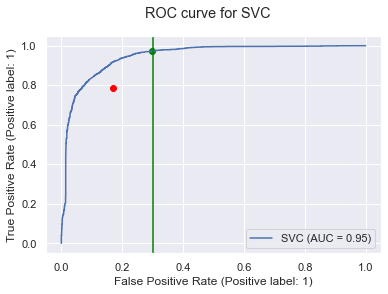


max fpr < 0.3 0.2992831541218638
max tpr with fpr < 0.3 0.9731040564373897


In [44]:
p4 = plot_roc_curve(svc, tf_X_train, tf_y_train)

score = svc.decision_function(tf_X_train)
fpr, tpr, thresholds = roc_curve(tf_y_train, score)
meanf = np.mean(fpr)
meant = np.mean(tpr)
meanth = np.mean(thresholds)

print(f'fpr is {meanf}')
print(f'tpr is {meant}')
print(f'threshold is {meanth}')

p4.figure_.suptitle("ROC curve for SVC")
plt.scatter([meanf], [meant], color = "red")

plt.axvline(x=0.3, color = "green")

maxfpr = max(fpr[fpr <= 0.3])
maxtpr = max(tpr[np.where(fpr == maxfpr)])

plt.scatter([maxfpr], [maxtpr], color = "green")

plt.show() 

print(f'\nmax fpr < 0.3 {maxfpr}')
print(f'max tpr with fpr < 0.3 {maxtpr}')

```Для SVC ситуация сравнимая, красная точка вычислена как средние фпр и тпр (потому что, в отличие от собственноручно написанной модели, SVC как будто нормально не позволяет вытащить из себя использованные параметры), зеленая точка с фпр < 0.3 находится правее, как и в случае с логитом, фпр там = 0.299, тпр - 0.97, так что трейдофф наверное оценимый в плане повышения тру позитив.```<br/>

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score). **HINT:** Do not forget about set jobs=-1 in the GridSearchCV init to speed up calculations.
* make conclusions about the model

In [45]:
data_ch = data[(data["author"] == "Чехов")][:3000]
data_tu = data[(data["author"] == "Тургенев")][:3000]
data_gor = data[(data["author"] == "Горький")][:3000]
data_go = data[(data["author"] == "Гоголь")][:3000]
data_do = data[(data["author"] == "Достоевский")][:3000]
data_br = data[(data["author"] == "Брюсов")][:3000]

data_all = data_ch.append(data_tu).append(data_gor).append(data_go).append(data_do).append(data_br)
data_all

,sentence,author,lemmas,bag results,tf-idf results
15000,Урбенин и Кузьма были заключены в арестантский...,Чехов,урбенин кузьма заключить арестантский дом имет...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15001,Я тоже изменился.,Чехов,измениться,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15002,Так вот и давайте заводить другие порядки! – ж...,Чехов,давать заводить другой порядок – живо сказать ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15003,"И клевер, и пасека, и телята, и крестьянская д...",Чехов,клевер пасека телёнок крестьянский девушка всё...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15004,"Насажали вас здесь, иродов, на нашу погибель!",Чехов,насажать ирод наш погибель,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
2995,"Неожиданно я увидел, что один из легионариев, ...",Брюсов,неожиданно увидеть легионарий отделиться строй...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2996,"Один из них, человек лет тридцати пяти, одетый...",Брюсов,человек год тридцать пять одетый обычно одеват...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2997,"Мне представилось, что такие происшествия были...",Брюсов,представиться такой происшествие новость знать...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2998,"И если Капитолий не был взят, то не боги были ...",Брюсов,капитолий взять бог тот причина гусь,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


```Есть желание работать с сбалансированными классами, поэтому здесь мы от каждого автора возьмем 3000 записей.```<br/>

In [46]:
from sklearn.multiclass import OneVsRestClassifier

all_X_train, all_X_test, all_y_train, all_y_test = train_test_split(np.vstack(data_all["tf-idf results"]), data_all["author"], test_size = 0.25, random_state = 0)

all_log = OneVsRestClassifier(Logit(0, 0, 10))

In [47]:
all_log_pred = cross_val_predict(all_log, all_X_train, all_y_train, cv = 5)

Precision:   0.48
Recall:   0.47
F1-measure:   0.47
Accuracy:   0.47


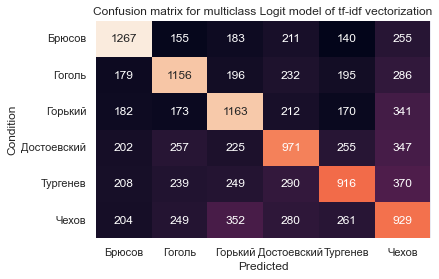

In [48]:
print("Precision: {0:6.2f}".format(precision_score(all_y_train, all_log_pred, average='macro', zero_division = 0)))
print("Recall: {0:6.2f}".format(recall_score(all_y_train, all_log_pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(all_y_train, all_log_pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(all_y_train, all_log_pred)))
labels = ["Брюсов","Гоголь","Горький","Достоевский",'Тургенев','Чехов']
     
sns.heatmap(data=confusion_matrix(all_y_train, all_log_pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix for multiclass Logit model of tf-idf vectorization")
plt.ylabel("Condition")
plt.xlabel("Predicted")
plt.show()

```Хотя метрики не слишком радующие, матрица в целом выглядит довольно хорошо, она почти диагональна, для каждых столбца и строки значение тру предикшенов - самое высокое, что неплохо. (да и вообще по всей матрицы самые большие значения это тру предикшены)```

Precision:   0.48
Accuracy:   0.48
Recall:   0.48
F1-measure:   0.48


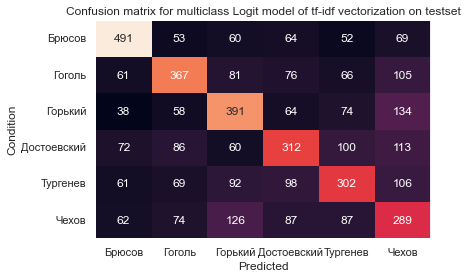

In [49]:
all_log_fit = all_log.fit(all_X_train, all_y_train)
all_log_pred_test = all_log_fit.predict(all_X_test)

print("Precision: {0:6.2f}".format(precision_score(all_y_test, all_log_pred_test, average='macro', zero_division = 0)))
print("Accuracy: {0:6.2f}".format(accuracy_score(all_y_test, all_log_pred_test)))
print("Recall: {0:6.2f}".format(recall_score(all_y_test, all_log_pred_test, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(all_y_test, all_log_pred_test, average='macro')))
labels = ["Брюсов","Гоголь","Горький","Достоевский",'Тургенев','Чехов']
     
sns.heatmap(data=confusion_matrix(all_y_test, all_log_pred_test), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix for multiclass Logit model of tf-idf vectorization on testset")
plt.ylabel("Condition")
plt.xlabel("Predicted")
plt.show()

```Метрики на тесте немного лучше, чем на трейне, значит модель по крайней мере наверное не переобучилась, матрица выглядит практически идентично, то есть на тесте мы тоже определяем их неплохо.```<br/>

In [55]:
betas = np.array([0.1, 1, 2])
gammas = np.array([0.1, 1, 2])
all_searcher = GridSearchCV(OneVsRestClassifier(Logit()), {"estimator__beta": betas, "estimator__gamma" : gammas}, scoring = "roc_auc_ovr", cv = 5)
all_searcher.fit(all_X_train, all_y_train)

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=Logit()),
             param_grid={'estimator__beta': array([0.1, 1. , 2. ]),
                         'estimator__gamma': array([0.1, 1. , 2. ])},
             scoring='roc_auc_ovr')

Best beta = 1.0
Best gamma = 2.0


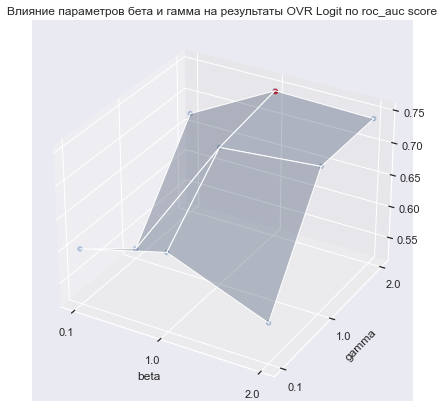

In [56]:
best_beta = all_searcher.best_params_["estimator__beta"]
best_gamma = all_searcher.best_params_["estimator__gamma"]

print(f'Best beta = {best_beta}')
print(f'Best gamma = {best_gamma}')
res = np.reshape(all_searcher.cv_results_["mean_test_score"], (3,3))
#print(searcherL.cv_results_)

z = res
x = [[betas[0], betas[0], betas[0]],[betas[1], betas[1], betas[1]],[betas[2], betas[2], betas[2]]]
y = [gammas,gammas,gammas]
 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, alpha = 0.3)
ax.scatter3D(best_beta, best_gamma, np.max(res), color = "red")
ax.plot_surface(x, y, z, alpha = 0.3)
ax.set_xticks(betas)
ax.set_yticks(gammas)
plt.title("Влияние параметров бета и гамма на результаты OVR Logit по roc_auc score")
plt.xlabel("beta")
plt.ylabel("gamma")
plt.show()

```Согласно грид серчу, лучшие параметры бета и гамма равны 1 и 2. На графике даже видно, что в целом есть тенденция роста в сторону выбранной точки, то есть это уже не такая же ситуация рандомных колебаний, как было для этих параметров для бинарной классификации.```<br/>

In [57]:
lrs = np.array([1e-2, 1, 5])
tolerances = np.array([1e-9, 1e-8, 1e-7])

iters = np.array([100, 1000, 10000])

all_searcher2 = GridSearchCV(OneVsRestClassifier(Logit(0, 0, 10)), {"estimator__lr": lrs, "estimator__tolerance" : tolerances}, scoring = "roc_auc_ovr", cv = 5, n_jobs=-1)
all_searcherI = GridSearchCV(OneVsRestClassifier(Logit(0, 0, 10)), {"estimator__max_iter": iters}, scoring = "roc_auc_ovr", cv = 5, n_jobs=-1)

all_searcher2.fit(all_X_train, all_y_train)
all_searcherI.fit(all_X_train, all_y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=Logit(beta=0, gamma=0,
                                                           lr=10)),
             param_grid={'estimator__max_iter': array([  100,  1000, 10000])},
             scoring='roc_auc_ovr')

Best learning rate = 5.0
Best tolerance = 1e-09


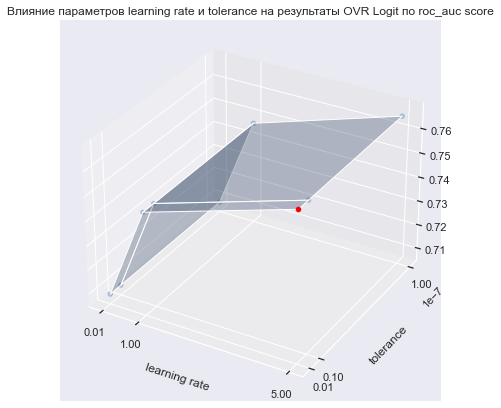

In [58]:
best_lr = all_searcher2.best_params_["estimator__lr"]
best_tolerance = all_searcher2.best_params_["estimator__tolerance"]

print(f'Best learning rate = {best_lr}')
print(f'Best tolerance = {best_tolerance}')
res2 = np.reshape(all_searcher2.cv_results_["mean_test_score"], (3,3))

z = res2
x = [[lrs[0], lrs[0], lrs[0]],[lrs[1], lrs[1], lrs[1]],[lrs[2], lrs[2], lrs[2]]]
y = [tolerances,tolerances,tolerances]
 
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, alpha = 0.3)
ax.plot_surface(x, y, z, alpha = 0.3)
ax.set_xticks(lrs)
ax.set_yticks(tolerances)
ax.scatter3D(best_lr, best_tolerance, np.max(res2), color = "red")
plt.title("Влияние параметров learning rate и tolerance на результаты OVR Logit по roc_auc score")
plt.xlabel("learning rate")
plt.ylabel("tolerance")
plt.show()

```Лучшие значения лернинг рейт и толеранс - 5 и 1e-9, при этом толеранс вообще никак не влияет на происходящее, а с лернинг рейт при увеличении с 0.01 до 1 наблюдается резкий рост, затем - более плавный. При этом снова все значения меняются от 0.71 до 0.76, так что чувствительность есть, но не драматичная.```<br/>

Best max_iter = 10000


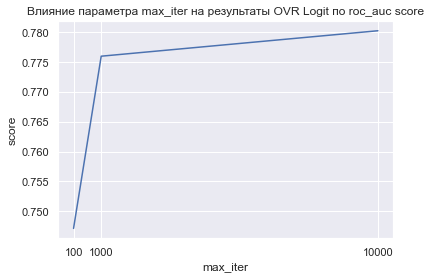

In [59]:
resI = all_searcherI.cv_results_["mean_test_score"]

best_iter = all_searcherI.best_params_["estimator__max_iter"]
print(f'Best max_iter = {best_iter}')

x = iters
y = resI

plt.plot(x, y)
plt.title("Влияние параметра max_iter на результаты OVR Logit по roc_auc score")
plt.xticks(iters)
plt.xlabel("max_iter")
plt.ylabel("score")
plt.show()

```Лучшее значение для количества итераций - 10000. Как и в случае бинарного классификатора, от 100 до 1000 рост резкий, далее же нет, изменения происходят от 0.75 при худшем значении до 0.78.```<br/><br/>```В целом можно сказать что OneVSRest модель работает не намного хуже бинарной. Метрики конечно ниже, но матрицы при этом все равно достаточно хорошие. Как показала моя попытка менять количество фич при векторизации, это намного сильнее влияет на результат, чем подбор оптимальных параметров модели. Однако большее число фич очень сильно замедляет вычисления (первый гридсерч в этом пункте считался 40 минут на 100 фичах и 12 часов на 5000), к тому же при выборе большого числа фич очень существенными становятся параметры устройства, на котором ведутся вычисления (попытка сделать 10000 фич у меня вызвала переполнение оперативной памяти, и при 5000 фич, что интересно, njobs = -1 замедляли работу, потому что создавали большую потерю по времени в боттлнеке оперативки, чем выигрыш по оптимизации работы немногих ядер. Последние 2 гридсерча вместе из-за этого вообще считались около 30 часов). При этом количество фич драматически влияет, например, на оптимальное количество итераций: гридсерч мне упорно показывал, что если фич 100, то чем меньше итераций, тем лучше, потому что видимо ничего хорошего из такого словаря вообще нельзя вынести, что и понятно, потому что тогда большая часть результатов векторизации будет состоять просто из нулей, и какой-либо вывод будет просто невозможно сделать.```<br/>```В целом, кажется, написанная нами модель, хоть и не так хорошо работает, как библиотечная, в целом почти не уступает ей, а главное все-таки выполняет то, что от нее требуется с параметрами лучше простого угадывания, значит может считаться работоспособной. Ура.```<br/><br/>```Короче говоря, было весело, спасибо.```